# Next Steps for Team

The core coding work is complete. The following tasks are needed to finalize the project:

### 1. Convert Code into Template Structure
- Move dataloader code → `twincar/dataset.py`
- Move training code → `twincar/modeling/train.py`
- Move prediction code → `twincar/modeling/predict.py`
- Keep this notebook only for experiments and plots

### 2. Improve Model Performance
- Train for 10–20 epochs
- Unfreeze the last ResNet block for fine-tuning after initial epochs
- Preferably train on more than the current 1500/300 subset if possible

### 3. Update Evaluation
- Recalculate metrics on the **full test set**
- Include:
  - Accuracy
  - Precision / Recall / F1 (macro)
  - Top-3 accuracy
  - Confusion matrix

### 4. Update Plots and Outputs
- Loss and accuracy curves (final run)
- Grad-CAM on new best model
- Save updated figures into `reports/figures/`

### 5. Documentation
- Write a complete **README** including:
  - Project goal + approach
  - How to install and run training
  - How to run predictions
  - Final results + visuals
- Add final predictions CSV into `reports/`

### 6. Presentation Materials
- Create final slides for project demo
- (Optional) Hugging Face model card + demo Space

---

Please continue from here. All working code and results up to this point are included in this notebook.


In [54]:
# ---------------------------------------
# Clean & Silent Environment Setup
# ---------------------------------------
import os
import warnings
import logging

# Disable symlink warnings on Windows
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

# Forces datasets to use simple text progress bars — no widgets
os.environ["HF_DATASETS_OFFLINE"] = "0"
os.environ["HF_DATASETS_DISABLE_PROGRESS_BARS"] = "1"

# Disable tqdm notebook widgets
os.environ["DISABLE_TQDM"] = "1"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# Hide user warnings originating in HF widgets/datasets
warnings.filterwarnings("ignore", category=UserWarning)

# Silence Hugging Face Hub logs completely
logging.getLogger("huggingface_hub").setLevel(logging.ERROR)

# Silence datasets logging
logging.getLogger("datasets").setLevel(logging.ERROR)



In [56]:
# ---------------------------------------
# Data & Dataloaders (Stanford Cars, subset)
# ---------------------------------------
from pathlib import Path

import torch
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from PIL import Image

# ---------------------------------------
# Paths
# ---------------------------------------
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

# ---------------------------------------
# Transforms (slightly smaller than 224x224 to speed up)
# ---------------------------------------
IMG_SIZE = 160

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.02),
    transforms.ToTensor(),
])

eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# ---------------------------------------
# Wrapper: HF dataset -> PyTorch Dataset
# ---------------------------------------
class CarsDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        img = item["image"]
        label = item["label"]

        # Ensure PIL image
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)

        # Force 3-channel RGB
        img = img.convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


# ---------------------------------------
# Load HF dataset (Stanford Cars)
# ---------------------------------------
hf_ds = load_dataset(
    "tanganke/stanford_cars",
    cache_dir=str(DATA_DIR / "hf_cache"),
)

train_hf = hf_ds["train"]
test_hf = hf_ds["test"]

train_ds_full = CarsDataset(train_hf, train_tf)
test_ds = CarsDataset(test_hf, eval_tf)

# ---------------------------------------
# Train/Val split (full)
# ---------------------------------------
val_ratio = 0.2
val_size = int(len(train_ds_full) * val_ratio)
train_size = len(train_ds_full) - val_size

train_ds, val_ds = random_split(
    train_ds_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42),
)

# ---------------------------------------
# REDUCE TRAIN/VAL TO SUBSETS FOR SPEED
# ---------------------------------------
max_train_samples = 1500
max_val_samples = 300

if len(train_ds) > max_train_samples:
    idx_train = torch.randperm(len(train_ds))[:max_train_samples]
    train_ds = Subset(train_ds, idx_train)
    print(f"Using reduced train subset of size: {len(train_ds)}")

if len(val_ds) > max_val_samples:
    idx_val = torch.randperm(len(val_ds))[:max_val_samples]
    val_ds = Subset(val_ds, idx_val)
    print(f"Using reduced val subset of size: {len(val_ds)}")

# ---------------------------------------
# DataLoaders
# ---------------------------------------
train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=0,
)

val_loader = DataLoader(
    val_ds,
    batch_size=32,
    shuffle=False,
    num_workers=0,
)

test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    num_workers=0,
)

# ---------------------------------------
# Quick sanity check
# ---------------------------------------
batch = next(iter(train_loader))
images, labels = batch
print("Train batch images:", images.shape)
print("Train batch labels:", labels.shape)
print("Original number of train samples:", len(train_ds_full))
print("Current train subset size:", len(train_ds))
print("Number of classes:", len(hf_ds['train'].features['label'].names))
print("Example classes:", hf_ds['train'].features['label'].names[:5])



Using reduced train subset of size: 1500
Using reduced val subset of size: 300
Train batch images: torch.Size([32, 3, 160, 160])
Train batch labels: torch.Size([32])
Original number of train samples: 8144
Current train subset size: 1500
Number of classes: 196
Example classes: ['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012']


In [58]:
# ---------------------------------------
# Training (ResNet-18 head, subset, GPU if available)
# ---------------------------------------
import torch
from torch import nn, optim
from torchvision import models
from pathlib import Path

# Use GPU if available, otherwise CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Directory to store trained models
PROJECT_DIR = Path(".")
MODELS_DIR = PROJECT_DIR / "models"
MODELS_DIR.mkdir(exist_ok=True)

# Number of classes from the HF dataset loaded in Bracket 2
num_classes = len(hf_ds["train"].features["label"].names)
print("Number of classes:", num_classes)


def build_resnet18_classifier(num_classes: int, fine_tune: bool = False):
    """
    ResNet-18 classifier.

    If fine_tune=False:
      - Freeze backbone
      - Train only final FC layer
    """
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    if not fine_tune:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True

    return model


def run_one_epoch(model, loader, optimizer, criterion, device, train_mode: bool = True):
    if train_mode:
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        if train_mode:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train_mode):
            outputs = model(images)
            loss = criterion(outputs, labels)

            if train_mode:
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def train_model(
    train_loader,
    val_loader,
    num_classes: int,
    num_epochs: int = 3,
    lr: float = 1e-3,
    weight_decay: float = 1e-4,
    ckpt_name: str = "stanford_cars_resnet18_head_subset.pt",
):
    model = build_resnet18_classifier(num_classes, fine_tune=False).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(trainable_params, lr=lr, weight_decay=weight_decay)

    best_val_acc = 0.0
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }

    ckpt_path = MODELS_DIR / ckpt_name

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = run_one_epoch(
            model, train_loader, optimizer, criterion, DEVICE, train_mode=True
        )
        val_loss, val_acc = run_one_epoch(
            model, val_loader, optimizer, criterion, DEVICE, train_mode=False
        )

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch {epoch:02d}/{num_epochs:02d} "
            f"- train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f} "
            f"- val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}"
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), ckpt_path)
            print(f"  -> New best model saved to {ckpt_path} (val_acc={val_acc:.4f})")

    print("Training complete. Best val_acc:", best_val_acc)
    return model, history, ckpt_path


# ---------------------------------------
# Run training
# ---------------------------------------
model, history, checkpoint_path = train_model(
    train_loader=train_loader,
    val_loader=val_loader,
    num_classes=num_classes,
    num_epochs=3,
    lr=1e-3,
    weight_decay=1e-4,
)

print("Checkpoint path:", checkpoint_path)



Using device: cpu
Number of classes: 196
Epoch 01/03 - train_loss: 5.7209, train_acc: 0.0093 - val_loss: 5.4143, val_acc: 0.0133
  -> New best model saved to models\stanford_cars_resnet18_head_subset.pt (val_acc=0.0133)
Epoch 02/03 - train_loss: 4.7683, train_acc: 0.0573 - val_loss: 5.1922, val_acc: 0.0300
  -> New best model saved to models\stanford_cars_resnet18_head_subset.pt (val_acc=0.0300)
Epoch 03/03 - train_loss: 4.2555, train_acc: 0.1547 - val_loss: 5.0618, val_acc: 0.0433
  -> New best model saved to models\stanford_cars_resnet18_head_subset.pt (val_acc=0.0433)
Training complete. Best val_acc: 0.043333333333333335
Checkpoint path: models\stanford_cars_resnet18_head_subset.pt


In [62]:
# ---------------------------------------
# Fast evaluation on a subset of the test set
# ---------------------------------------
import torch
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Rebuild the same model architecture and load best weights
eval_model = build_resnet18_classifier(num_classes, fine_tune=False).to(DEVICE)

# Safe load of weights
state_dict = torch.load(
    "models/stanford_cars_resnet18_head_subset.pt",
    map_location=DEVICE,
)
eval_model.load_state_dict(state_dict)
eval_model.eval()


def evaluate_model_subset(model, loader, device, max_batches: int = 20):
    """
    Evaluate model on at most `max_batches` from the loader
    to keep evaluation fast on CPU.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            if batch_idx >= max_batches:
                break

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total if total > 0 else 0.0
    return acc, total, max_batches


max_batches = 20
test_acc_sub, n_samples, max_b = evaluate_model_subset(
    eval_model, test_loader, DEVICE, max_batches=max_batches
)

print(f"Evaluated on {n_samples} test images (max {max_b} batches).")
print(f"Approximate test accuracy: {test_acc_sub:.4f}")


Evaluated on 640 test images (max 20 batches).
Approximate test accuracy: 0.0500


In [64]:
# ---------------------------------------
# Batch prediction for custom images (Option B: Full Windows path)
# ---------------------------------------
from pathlib import Path
from PIL import Image
import pandas as pd
from torchvision import transforms
import torch

# Same IMG_SIZE as in Bracket 2
predict_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Label names from HF dataset
label_names = hf_ds["train"].features["label"].names


def predict_image_paths(image_paths, model, device):
    records = []

    model.eval()
    with torch.no_grad():
        for img_path in image_paths:
            img = Image.open(img_path).convert("RGB")
            x = predict_tf(img).unsqueeze(0).to(device)

            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            conf, pred_idx = torch.max(probs, dim=1)

            pred_idx = pred_idx.item()
            confidence = conf.item()
            label_str = label_names[pred_idx]

            records.append({
                "image_path": str(img_path),
                "pred_label": label_str,
                "confidence": confidence,
            })

    return pd.DataFrame(records)


# ---------------------------------------
# FULL WINDOWS PATH
# ---------------------------------------
pred_dir = Path(r"C:\Users\Filip\Desktop\Data ML\external\prediction_samples")

pred_dir.mkdir(parents=True, exist_ok=True)

image_paths = sorted(
    list(pred_dir.glob("*.jpg")) +
    list(pred_dir.glob("*.jpeg")) +
    list(pred_dir.glob("*.png"))
)

if not image_paths:
    print(f"No images found in {pred_dir}. Put some car images there (jpg/png) and rerun.")
else:
    df_preds = predict_image_paths(image_paths, eval_model, DEVICE)
    print(df_preds)

    # Save CSV
    out_csv = Path("reports") / "predictions_custom_images.csv"
    out_csv.parent.mkdir(parents=True, exist_ok=True)
    df_preds.to_csv(out_csv, index=False)
    print(f"Saved predictions to {out_csv}")


                                          image_path  \
0  C:\Users\Filip\Desktop\Data ML\external\predic...   
1  C:\Users\Filip\Desktop\Data ML\external\predic...   
2  C:\Users\Filip\Desktop\Data ML\external\predic...   
3  C:\Users\Filip\Desktop\Data ML\external\predic...   
4  C:\Users\Filip\Desktop\Data ML\external\predic...   
5  C:\Users\Filip\Desktop\Data ML\external\predic...   

                                   pred_label  confidence  
0              Volkswagen Golf Hatchback 2012    0.041375  
1                      Ford Fiesta Sedan 2012    0.034477  
2                     Toyota Sequoia SUV 2012    0.036470  
3                      Audi TT Hatchback 2011    0.030889  
4  Bentley Continental Flying Spur Sedan 2007    0.022700  
5                      Ford Fiesta Sedan 2012    0.056838  
Saved predictions to reports\predictions_custom_images.csv


In [66]:
# ---------------------------------------
# Classification Report on test subset
# ---------------------------------------
from sklearn.metrics import classification_report
import torch

eval_model.eval()

all_labels = []
all_preds = []

max_batches = 20  # same as evaluation subset
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        if batch_idx >= max_batches:
            break

        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = eval_model(images)
        _, preds = outputs.max(1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Compute macro metrics (fair for imbalanced multi-class)
report = classification_report(
    all_labels,
    all_preds,
    labels=list(range(num_classes)),
    target_names=label_names,
    zero_division=0,
    output_dict=True
)

# Extract macro metrics only
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")


Macro Precision: 0.0223
Macro Recall:    0.0046
Macro F1-score:  0.0053


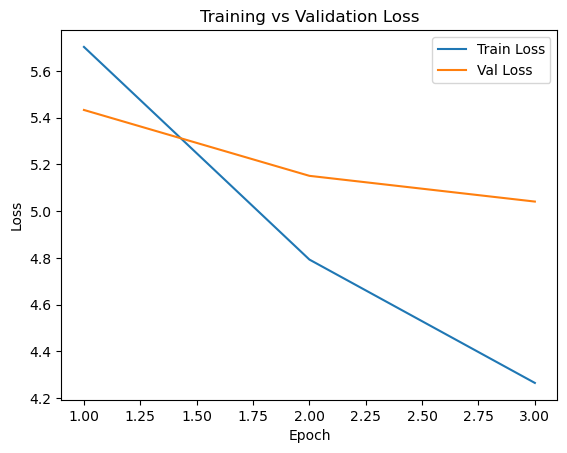

Saved loss curve to: reports\figures\loss_curve.png


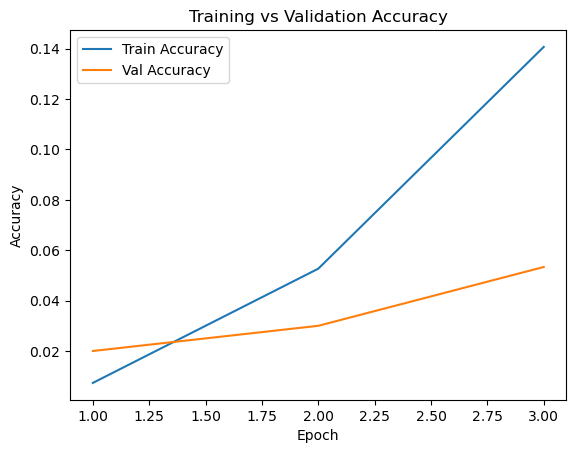

Saved accuracy curve to: reports\figures\accuracy_curve.png


In [33]:
# ---------------------------------------
# Training curves (Loss & Accuracy)
# ---------------------------------------
import matplotlib.pyplot as plt
from pathlib import Path

# Make sure the figures directory exists
fig_dir = Path("reports") / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

epochs = range(1, len(history["train_loss"]) + 1)

# ---- Loss curve ----
plt.figure()
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
loss_path = fig_dir / "loss_curve.png"
plt.savefig(loss_path, bbox_inches="tight")
plt.show()
print(f"Saved loss curve to: {loss_path}")

# ---- Accuracy curve ----
plt.figure()
plt.plot(epochs, history["train_acc"], label="Train Accuracy")
plt.plot(epochs, history["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
acc_path = fig_dir / "accuracy_curve.png"
plt.savefig(acc_path, bbox_inches="tight")
plt.show()
print(f"Saved accuracy curve to: {acc_path}")


In [68]:
# ---------------------------------------
# Enhance predictions: split Make / Model / Year
# ---------------------------------------
def parse_label(label_str):
    """
    Example input: "BMW X3 SUV 2012"
    Output: make="BMW", model="X3 SUV", year="2012"
    """
    parts = label_str.split()
    year = parts[-1] if parts[-1].isdigit() else None
    make = parts[0]
    model = " ".join(parts[1:-1]) if year else " ".join(parts[1:])
    return make, model, year


if "pred_label" in df_preds.columns:
    df_preds["pred_make"] = df_preds["pred_label"].apply(lambda s: parse_label(s)[0])
    df_preds["pred_model"] = df_preds["pred_label"].apply(lambda s: parse_label(s)[1])
    df_preds["pred_year"] = df_preds["pred_label"].apply(lambda s: parse_label(s)[2])

    print(df_preds[["image_path", "pred_make", "pred_model", "pred_year", "confidence"]])
    
    # Save updated CSV
    df_preds.to_csv(out_csv, index=False)
    print(f"Updated predictions saved to {out_csv}")
else:
    print("Run prediction first.")


                                          image_path   pred_make  \
0  C:\Users\Filip\Desktop\Data ML\external\predic...  Volkswagen   
1  C:\Users\Filip\Desktop\Data ML\external\predic...        Ford   
2  C:\Users\Filip\Desktop\Data ML\external\predic...      Toyota   
3  C:\Users\Filip\Desktop\Data ML\external\predic...        Audi   
4  C:\Users\Filip\Desktop\Data ML\external\predic...     Bentley   
5  C:\Users\Filip\Desktop\Data ML\external\predic...        Ford   

                      pred_model pred_year  confidence  
0                 Golf Hatchback      2012    0.041375  
1                   Fiesta Sedan      2012    0.034477  
2                    Sequoia SUV      2012    0.036470  
3                   TT Hatchback      2011    0.030889  
4  Continental Flying Spur Sedan      2007    0.022700  
5                   Fiesta Sedan      2012    0.056838  
Updated predictions saved to reports\predictions_custom_images.csv


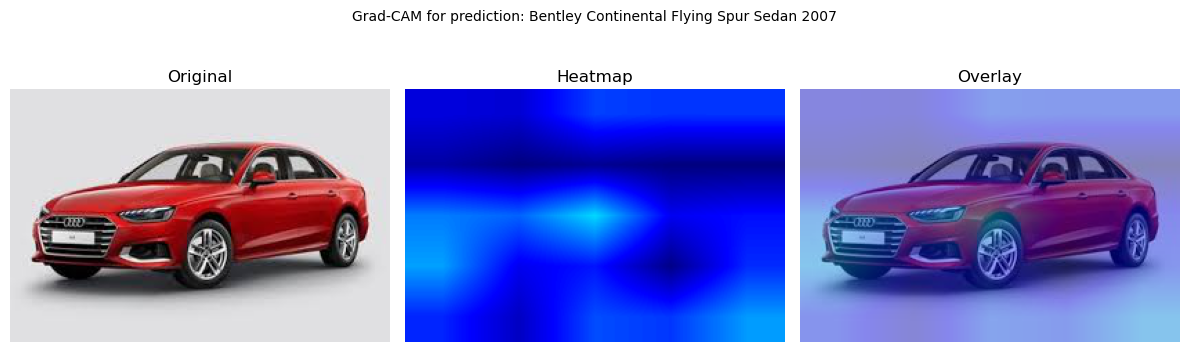

Saved Grad-CAM example 1 to reports\figures\gradcam_example_1.png


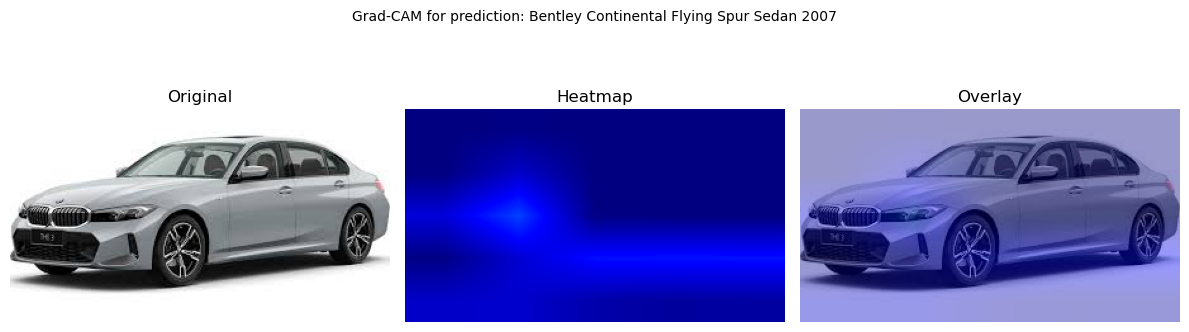

Saved Grad-CAM example 2 to reports\figures\gradcam_example_2.png


In [76]:
# ---------------------------------------
# Optional: Grad-CAM Explainability
# ---------------------------------------
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2

# 1) Ensure model allows gradients (undo freezing for explainability)
for p in eval_model.parameters():
    p.requires_grad_(True)

eval_model.train()

# 2) Target layer: last conv block of ResNet-18
target_layer = eval_model.layer4[1].conv2


def generate_gradcam(model, img_path, device):
    model.zero_grad()

    # Load and preprocess image
    pil_img = Image.open(img_path).convert("RGB")
    input_tensor = predict_tf(pil_img).unsqueeze(0).to(device)

    activations = []
    gradients = []

    # Forward hook: save activations and attach grad hook to output tensor
    def forward_hook(module, inp, out):
        activations.append(out)

        if out.requires_grad:
            def grad_hook(grad):
                gradients.append(grad)
            out.register_hook(grad_hook)

    # Register forward hook
    h_f = target_layer.register_forward_hook(forward_hook)

    # Forward pass
    logits = model(input_tensor)
    pred_class = logits.argmax(dim=1).item()
    score = logits[:, pred_class]

    # Backward pass
    score.backward()

    # Remove hook
    h_f.remove()

    if not activations or not gradients:
        raise RuntimeError("Failed to capture activations/gradients for Grad-CAM.")

    # Get stored tensors
    act = activations[0].detach()[0]
    grad = gradients[0].detach()[0]

    # Global-average-pool gradients -> weights
    weights = grad.mean(dim=(1, 2))

    # Weighted sum of activations
    cam = torch.zeros(act.shape[1:], dtype=torch.float32)
    for w, a in zip(weights, act):
        cam += w * a

    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    cam_np = cam.cpu().numpy()

    # Resize CAM to image size
    img_np = np.array(pil_img)
    h, w, _ = img_np.shape
    cam_resized = cv2.resize(cam_np, (w, h))

    # Colorize heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay
    overlay = np.uint8(255 * (0.4 * heatmap / 255.0 + 0.6 * img_np / 255.0))

    return img_np, heatmap, overlay, pred_class


# 3) Run Grad-CAM on first 2 prediction images
fig_dir = Path("reports") / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

num_examples = min(2, len(image_paths))
for i in range(num_examples):
    img_path = image_paths[i]
    img_np, heatmap, overlay, pred_class = generate_gradcam(eval_model, img_path, DEVICE)
    label_str = label_names[pred_class]

    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Grad-CAM for prediction: {label_str}", fontsize=10)

    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title("Original")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.axis("off")
    plt.title("Heatmap")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Overlay")

    out_path = fig_dir / f"gradcam_example_{i+1}.png"
    plt.tight_layout()
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()
    print(f"Saved Grad-CAM example {i+1} to {out_path}")


In [41]:
# ---------------------------------------
# Optional: Top-k accuracy & confusion matrix
# ---------------------------------------
from sklearn.metrics import confusion_matrix
import numpy as np

def evaluate_topk_and_confmat(model, loader, device, k=3, max_batches=20):
    model.eval()
    all_labels = []
    all_preds = []
    topk_correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            if batch_idx >= max_batches:
                break

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = outputs.max(1)

            # Top-k
            topk_probs, topk_indices = outputs.topk(k, dim=1)
            in_topk = (topk_indices == labels.unsqueeze(1)).any(dim=1)
            topk_correct += in_topk.sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            total += labels.size(0)

    top1_acc = (np.array(all_preds) == np.array(all_labels)).mean()
    topk_acc = topk_correct / total

    # Confusion matrix on this subset (196x196, but used mainly for summary)
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))

    return top1_acc, topk_acc, cm


top1_acc_sub, top3_acc_sub, cm_sub = evaluate_topk_and_confmat(
    eval_model, test_loader, DEVICE, k=3, max_batches=20
)

print(f"Subset top-1 accuracy: {top1_acc_sub:.4f}")
print(f"Subset top-3 accuracy: {top3_acc_sub:.4f}")
print(f"Confusion matrix shape (subset): {cm_sub.shape}")


Subset top-1 accuracy: 0.0672
Subset top-3 accuracy: 0.1375
Confusion matrix shape (subset): (196, 196)


In [82]:
# ---------------------------------------
# Optional: Export model to ONNX
# ---------------------------------------
import torch.onnx
from pathlib import Path

onnx_path = Path("models") / "stanford_cars_resnet18_head_subset.onnx"

# Export on CPU
eval_model_cpu = eval_model.to("cpu").eval()
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE, device="cpu")

torch.onnx.export(
    eval_model_cpu,
    dummy_input,
    onnx_path,
    input_names=["input"],
    output_names=["logits"],
    dynamic_axes={"input": {0: "batch_size"}, "logits": {0: "batch_size"}},
    opset_version=11,
)

print(f"Exported ONNX model to: {onnx_path}")


Exported ONNX model to: models\stanford_cars_resnet18_head_subset.onnx
